In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from functools import reduce
from sklearn.model_selection import GridSearchCV
from statistics import mean, stdev
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import TomekLinks
from matplotlib import pyplot as plt
from sklearn.utils import class_weight
from scipy.interpolate import splrep, splev
from scipy.interpolate import make_interp_spline
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

In [9]:
temp = pd.read_csv('C:/Users/s3929438/all_features_mobile_100_non_con.csv')

In [11]:
temp.iloc[:,3:8]

,Error_rate_%,WPM,neg_UD_%,neg_UU_%,Other
0,23.0,31.875000,2.565283,0.000000,0
1,13.0,34.545455,2.565283,0.000000,0
2,8.0,31.666667,3.030303,0.000000,0
3,16.0,36.000000,2.020202,0.000000,0
4,17.0,33.529412,2.020202,0.000000,0
...,...,...,...,...,...
5354,11.0,30.857143,1.010101,1.010101,0
5355,7.0,37.500000,1.236858,0.000000,0
5356,8.0,44.444444,1.236858,0.000000,0
5357,7.0,22.500000,1.236858,0.000000,0


In [325]:
# Feature selection for NC+TEMp+CKP for desktop
selected_features = ['Error_rate_%', 'WPM', 'neg_UD_%', 'LSA_ratio',
       'Hold_time', 'mean_F1', 'mean_F2', 'mean_F3', 'mean_F4', 'Tri_graph',
       'mean_F1_se', 'mean_F2_se', 'mean_F3_se', 'mean_F4_se', 'mean_F1_th',
       'mean_F2_th', 'mean_F3_th', 'mean_F4_th', 'mean_F1_he']

# # Feature selection for NC+TEMp+CKP for mobile
# selected_features = ['Error_rate_%', 'WPM', 'neg_UD_%', 'Tri_graph', 'mean_hold_time',
#        'mean_F1', 'mean_F2', 'mean_F3', 'mean_F4', 'mean_F1_se', 'mean_F2_se',
#        'mean_F3_se', 'mean_F4_se', 'mean_F1_th', 'mean_F2_th', 'mean_F3_th',
#        'mean_F4_th', 'mean_F1_le', 'mean_F2_le', 'mean_F3_le', 'mean_F4_le']

# # Feature selection for NC+TEMp+CKP for tablet
# selected_features = ['Tri_graph', 'Error_rate_%', 'WPM', 'neg_UD_%', 'mean_hold_time',
#        'mean_F1', 'mean_F2', 'mean_F3', 'mean_F4', 'mean_F1_se', 'mean_F2_se',
#        'mean_F3_se', 'mean_F4_se', 'mean_F1_th', 'mean_F2_th', 'mean_F3_th',
#        'mean_F4_th', 'mean_F1_le', 'mean_F2_le', 'mean_F3_le', 'mean_F4_le']

In [12]:
round_1_prob = []
round_2_prob = []
round_3_prob = []
round_4_prob = []
round_5_prob = []

round_1_lbl = []
round_2_lbl = []
round_3_lbl = []
round_4_lbl = []
round_5_lbl = []

round_1_pred_lbl = []
round_2_pred_lbl = []
round_3_pred_lbl = []
round_4_pred_lbl = []
round_5_pred_lbl = []


for a,i in enumerate (temp['User'].unique()):
# for i in range (1,3):
    user_set = temp[temp['User']==i]
    other_set = temp[temp['User']!=i]
    user_id = i
              
    user_set.insert(loc = len(user_set.columns),column = 'User_type',value = 1)
    other_set.insert(loc = len(other_set.columns),column = 'User_type',value = 0)
    
    final_set = user_set.append(other_set)
    
    x = final_set.iloc[:,3:8]
    y = final_set['User_type']
    
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    resample = SMOTE(random_state=42)
    
#     model_sl = xgb.XGBClassifier(colsample_bytree = 0.3,min_child_weight = 2,max_depth = 4)
    model_sl = xgb.XGBClassifier(
        max_depth =5,min_child_weight=5,learning_rate=0.1, subsample=0.7,colsample_bytree=0.5,
                                    scale_pos_weight = 0.9
                                )
    
    
    for s , (train_index , test_index) in enumerate (skf.split(x,y)):
        if s==0:
            fold_1 = []
            pred_lbl1 = []
            labels_1 = []
            X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
            y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
            x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
            model_sl.fit(x_train_res,y_train_res)
            pred_values = model_sl.predict(X_test)
            predict_probs = model_sl.predict_proba(X_test)
            true_label = y_test
        
            fold_1.append(predict_probs[:,-1].tolist())
            labels_1.append(true_label.to_list())
            pred_lbl1.append(pred_values.tolist())
            
        if s==1:
            fold_2 = []
            labels_2 = []
            pred_lbl2 = []
            X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
            y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
            x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
            model_sl.fit(x_train_res,y_train_res)
            pred_values = model_sl.predict(X_test)
            predict_probs = model_sl.predict_proba(X_test)
            true_label = y_test
        
            fold_2.append(predict_probs[:,-1].tolist())
            labels_2.append(true_label.to_list())
            pred_lbl2.append(pred_values.tolist())
            
        if s==2:
            fold_3 = []
            labels_3 = []
            pred_lbl3 = []
            X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
            y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
            x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
            model_sl.fit(x_train_res,y_train_res)
            pred_values = model_sl.predict(X_test)
            predict_probs = model_sl.predict_proba(X_test)
            true_label = y_test
        
            fold_3.append(predict_probs[:,-1].tolist())
            labels_3.append(true_label.to_list())
            pred_lbl3.append(pred_values.tolist())
            
        if s==3:
            fold_4 = []
            labels_4 = []
            pred_lbl4 = []
            X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
            y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
            x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
            model_sl.fit(x_train_res,y_train_res)
            pred_values = model_sl.predict(X_test)
            predict_probs = model_sl.predict_proba(X_test)
            true_label = y_test
        
            fold_4.append(predict_probs[:,-1].tolist())
            labels_4.append(true_label.to_list())
            pred_lbl4.append(pred_values.tolist())
                
        if s==4:
            fold_5 = []
            labels_5 = []
            pred_lbl5 = []
            X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
            y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
            x_train_res, y_train_res = resample.fit_resample(X_train, y_train)
        
            model_sl.fit(x_train_res,y_train_res)
            pred_values = model_sl.predict(X_test)
            predict_probs = model_sl.predict_proba(X_test)
            true_label = y_test
        
            fold_5.append(predict_probs[:,-1].tolist())
            labels_5.append(true_label.to_list())
            pred_lbl5.append(pred_values.tolist())
                
    round_1_prob.append(fold_1[0])
    round_2_prob.append(fold_2[0])
    round_3_prob.append(fold_3[0])
    round_4_prob.append(fold_4[0])
    round_5_prob.append(fold_5[0])
        
    round_1_lbl.append(labels_1[0])
    round_2_lbl.append(labels_2[0])
    round_3_lbl.append(labels_3[0])
    round_4_lbl.append(labels_4[0])
    round_5_lbl.append(labels_5[0])
    
    round_1_pred_lbl.append(pred_lbl1[0])
    round_2_pred_lbl.append(pred_lbl2[0])
    round_3_pred_lbl.append(pred_lbl3[0])
    round_4_pred_lbl.append(pred_lbl4[0])
    round_5_pred_lbl.append(pred_lbl5[0])

In [13]:
for z in range(0,116):
    if z == 0:
        append_all_fold1 = round_1_prob[z]
        append_all_label1 = round_1_lbl[z]
        append_all_pred_label1 = round_1_pred_lbl[z]
    else:
        append_all_fold1 = append_all_fold1 + round_1_prob[z]
        append_all_label1 = append_all_label1 + round_1_lbl[z]
        append_all_pred_label1 = append_all_pred_label1 + round_1_pred_lbl[z]
        
# for a,x in enumerate (all_merged['User'].unique()):
for z in range (0,116):
    if z == 0:
        append_all_fold2 = round_2_prob[z]
        append_all_label2 = round_2_lbl[z]
        append_all_pred_label2 = round_2_pred_lbl[z]
    else:
        append_all_fold2 = append_all_fold2 + round_2_prob[z]
        append_all_label2 = append_all_label2 + round_2_lbl[z]
        append_all_pred_label2 = append_all_pred_label2 + round_2_pred_lbl[z]
        
# for a,x in enumerate (all_merged['User'].unique()):
for z in range (0,116):
    if z == 0:
        append_all_fold3 = round_3_prob[z]
        append_all_label3 = round_3_lbl[z]
        append_all_pred_label3 = round_3_pred_lbl[z]
    else:
        append_all_fold3 = append_all_fold3 + round_3_prob[z]
        append_all_label3 = append_all_label3 + round_3_lbl[z]
        append_all_pred_label3 = append_all_pred_label3 + round_3_pred_lbl[z]
        
# for a,x in enumerate (all_merged['User'].unique()):
for z in range (0,116):
    if z == 0:
        append_all_fold4 = round_4_prob[z]
        append_all_label4 = round_4_lbl[z]
        append_all_pred_label4 = round_4_pred_lbl[z]
    else:
        append_all_fold4 = append_all_fold4 + round_4_prob[z]
        append_all_label4 = append_all_label4 + round_4_lbl[z]
        append_all_pred_label4 = append_all_pred_label4 + round_4_pred_lbl[z]
        
# for a,x in enumerate (all_merged['User'].unique()):
for z in range (0,116):
    if z == 0:
        append_all_fold5 = round_5_prob[z]
        append_all_label5 = round_5_lbl[z]
        append_all_pred_label5 = round_5_pred_lbl[z]
    else:
        append_all_fold5 = append_all_fold5 + round_5_prob[z]
        append_all_label5 = append_all_label5 + round_5_lbl[z]
        append_all_pred_label5 = append_all_pred_label5 + round_5_pred_lbl[z]

In [14]:
Final_results_df_all = pd.DataFrame(list(zip(append_all_fold1,append_all_label1,append_all_fold2,append_all_label2,
                                             append_all_fold3,append_all_label3, append_all_fold4,append_all_label4,
                                             append_all_fold5, append_all_label5,append_all_pred_label1,append_all_pred_label2,
                                            append_all_pred_label3,append_all_pred_label4,append_all_pred_label5)),
        columns =['Fold_1_pro','Fold_1_tl', 'Fold_2_pro', 'Fold_2_tl','Fold_3_pro','Fold_3_tl','Fold_4_pro','Fold_4_tl',
                  'Fold_5_pro', 'Fold_5_tl','Fold_1_pl','Fold_2_pl','Fold_3_pl','Fold_4_pl','Fold_5_pl'])

In [15]:
Final_results_df_all.to_csv('Probabilities_mobile_onlyNC.csv')

# Desktop

In [331]:
nc = pd.read_csv('C:/Users/s3929438/Probabilities_desktop_onlyNC.csv')
temp = pd.read_csv('C:/Users/s3929438/Probabilities_desktop_onlyTemp.csv')
nctemp = pd.read_csv('C:/Users/s3929438/Probabilities_desktop_NC_TEMP.csv')
deft = pd.read_csv('C:/Users/s3929438/Probabilities_XGboost_desktop.csv')
ckp = pd.read_csv('C:/Users/s3929438/Probabilities_desktop_without_deft_ed.csv')

# NC

In [74]:
fpr1_nc, tpr1_nc, _ = roc_curve(nc.iloc[:,2], nc.iloc[:,1])
fpr2_nc, tpr2_nc, _ = roc_curve(nc.iloc[:,4], nc.iloc[:,3])
fpr3_nc, tpr3_nc, _ = roc_curve(nc.iloc[:,6], nc.iloc[:,5])
fpr4_nc, tpr4_nc, _ = roc_curve(nc.iloc[:,8], nc.iloc[:,7])
fpr5_nc, tpr5_nc, _ = roc_curve(nc.iloc[:,10], nc.iloc[:,9])

In [75]:
fpr_list_nc = [fpr1_nc, fpr2_nc,fpr3_nc,fpr4_nc,fpr5_nc]
tpr_list_nc = [tpr1_nc, tpr2_nc,tpr3_nc,tpr4_nc,tpr5_nc]
# fnr_list = [fnr1, fnr2,fnr3,fnr4,fnr5]

In [76]:
max_length_nc = max(len(fprs) for fprs in fpr_list_nc)

In [77]:
for i in range(0,5):
    if len(fpr_list_nc[i]) < max_length_nc:
        fpr_list_nc[i] = np.pad(fpr_list_nc[i], (0, max_length_nc - len(fpr_list_nc[i])), constant_values=1)

In [78]:
for i in range(0,5):
    if len(tpr_list_nc[i]) < max_length_nc:
        tpr_list_nc[i] = np.pad(tpr_list_nc[i], (0, max_length_nc - len(tpr_list_nc[i])), constant_values=1)

In [79]:
mean_fpr_nc = np.mean(fpr_list_nc, axis=0)
mean_tpr_nc = np.mean(tpr_list_nc, axis=0)

# TEMP

In [28]:
fpr1_temp, tpr1_temp, _ = roc_curve(temp.iloc[:,2], temp.iloc[:,1])
fpr2_temp, tpr2_temp, _ = roc_curve(temp.iloc[:,4], temp.iloc[:,3])
fpr3_temp, tpr3_temp, _ = roc_curve(temp.iloc[:,6], temp.iloc[:,5])
fpr4_temp, tpr4_temp, _ = roc_curve(temp.iloc[:,8], temp.iloc[:,7])
fpr5_temp, tpr5_temp, _ = roc_curve(temp.iloc[:,10], temp.iloc[:,9])

In [34]:
fpr_list_temp = [fpr1_temp, fpr2_temp,fpr3_temp,fpr4_temp,fpr5_temp]
tpr_list_temp = [tpr1_temp, tpr2_temp,tpr3_temp,tpr4_temp,tpr5_temp]
# fnr_list = [fnr1, fnr2,fnr3,fnr4,fnr5]

In [40]:
max_length_temp = max(len(fprs) for fprs in fpr_list_temp)

In [41]:
for i in range(0,5):
    if len(fpr_list_temp[i]) < max_length_temp:
        fpr_list_temp[i] = np.pad(fpr_list_temp[i], (0, max_length_temp - len(fpr_list_temp[i])), constant_values=1)

In [42]:
for i in range(0,5):
    if len(tpr_list_temp[i]) < max_length_temp:
        tpr_list_temp[i] = np.pad(tpr_list_temp[i], (0, max_length_temp - len(tpr_list_temp[i])), constant_values=1)

In [43]:
mean_fpr_temp = np.mean(fpr_list_temp, axis=0)
mean_tpr_temp = np.mean(tpr_list_temp, axis=0)

# NC + TEMP

In [98]:
fpr1_nctemp, tpr1_nctemp, _ = roc_curve(nctemp.iloc[:,2], nctemp.iloc[:,1])
fpr2_nctemp, tpr2_nctemp, _ = roc_curve(nctemp.iloc[:,4], nctemp.iloc[:,3])
fpr3_nctemp, tpr3_nctemp, _ = roc_curve(nctemp.iloc[:,6], nctemp.iloc[:,5])
fpr4_nctemp, tpr4_nctemp, _ = roc_curve(nctemp.iloc[:,8], nctemp.iloc[:,7])
fpr5_nctemp, tpr5_nctemp, _ = roc_curve(nctemp.iloc[:,10], nctemp.iloc[:,9])

In [99]:
fpr_list_nctemp = [fpr1_nctemp, fpr2_nctemp,fpr3_nctemp,fpr4_nctemp,fpr5_nctemp]
tpr_list_nctemp = [tpr1_nctemp, tpr2_nctemp,tpr3_nctemp,tpr4_nctemp,tpr5_nctemp]

In [100]:
max_length_nctemp = max(len(fprs) for fprs in fpr_list_nctemp)

In [101]:
for i in range(0,5):
    if len(fpr_list_nctemp[i]) < max_length_nctemp:
        fpr_list_nctemp[i] = np.pad(fpr_list_nctemp[i], (0, max_length_nctemp - len(fpr_list_nctemp[i])), constant_values=1)

In [102]:
for i in range(0,5):
    if len(tpr_list_nctemp[i]) < max_length_nctemp:
        tpr_list_nctemp[i] = np.pad(tpr_list_nctemp[i], (0, max_length_nctemp - len(tpr_list_nctemp[i])), constant_values=1)

In [103]:
mean_fpr_nctemp = np.mean(fpr_list_nctemp, axis=0)
mean_tpr_nctemp = np.mean(tpr_list_nctemp, axis=0)

# CKP

In [332]:
fpr1_ckp, tpr1_ckp, _ = roc_curve(ckp.iloc[:,2], ckp.iloc[:,1])
fpr2_ckp, tpr2_ckp, _ = roc_curve(ckp.iloc[:,4], ckp.iloc[:,3])
fpr3_ckp, tpr3_ckp, _ = roc_curve(ckp.iloc[:,6], ckp.iloc[:,5])
fpr4_ckp, tpr4_ckp, _ = roc_curve(ckp.iloc[:,8], ckp.iloc[:,7])
fpr5_ckp, tpr5_ckp, _ = roc_curve(ckp.iloc[:,10], ckp.iloc[:,9])

In [333]:
fpr_list_ckp = [fpr1_ckp, fpr2_ckp,fpr3_ckp,fpr4_ckp,fpr5_ckp]
tpr_list_ckp = [tpr1_ckp, tpr2_ckp,tpr3_ckp,tpr4_ckp,tpr5_ckp]

In [334]:
max_length_ckp = max(len(fprs) for fprs in fpr_list_ckp)

In [335]:
for i in range(0,5):
    if len(fpr_list_ckp[i]) < max_length_ckp:
        fpr_list_ckp[i] = np.pad(fpr_list_ckp[i], (0, max_length_ckp - len(fpr_list_ckp[i])), constant_values=1)

In [336]:
for i in range(0,5):
    if len(tpr_list_ckp[i]) < max_length_ckp:
        tpr_list_ckp[i] = np.pad(tpr_list_ckp[i], (0, max_length_ckp - len(tpr_list_ckp[i])), constant_values=1)

In [337]:
mean_fpr_ckp = np.mean(fpr_list_ckp, axis=0)
mean_tpr_ckp = np.mean(tpr_list_ckp, axis=0)

# DEFT

In [106]:
fpr1_deft, tpr1_deft, _ = roc_curve(deft.iloc[:,2], deft.iloc[:,1])
fpr2_deft, tpr2_deft, _ = roc_curve(deft.iloc[:,4], deft.iloc[:,3])
fpr3_deft, tpr3_deft, _ = roc_curve(deft.iloc[:,6], deft.iloc[:,5])
fpr4_deft, tpr4_deft, _ = roc_curve(deft.iloc[:,8], deft.iloc[:,7])
fpr5_deft, tpr5_deft, _ = roc_curve(deft.iloc[:,10], deft.iloc[:,9])

In [107]:
fpr_list_deft = [fpr1_deft, fpr2_deft,fpr3_deft,fpr4_deft,fpr5_deft]
tpr_list_deft = [tpr1_deft, tpr2_deft,tpr3_deft,tpr4_deft,tpr5_deft]
# fnr_list = [fnr1, fnr2,fnr3,fnr4,fnr5]

In [108]:
max_length_deft = max(len(fprs) for fprs in fpr_list_deft)

In [109]:
for i in range(0,5):
    if len(fpr_list_deft[i]) < max_length_deft:
        fpr_list_deft[i] = np.pad(fpr_list_deft[i], (0, max_length_deft - len(fpr_list_deft[i])), constant_values=1)

In [110]:
for i in range(0,5):
    if len(tpr_list_deft[i]) < max_length_deft:
        tpr_list_deft[i] = np.pad(tpr_list_deft[i], (0, max_length_deft - len(tpr_list_deft[i])), constant_values=1)

In [111]:
mean_fpr_deft = np.mean(fpr_list_deft, axis=0)
mean_tpr_deft = np.mean(tpr_list_deft, axis=0)

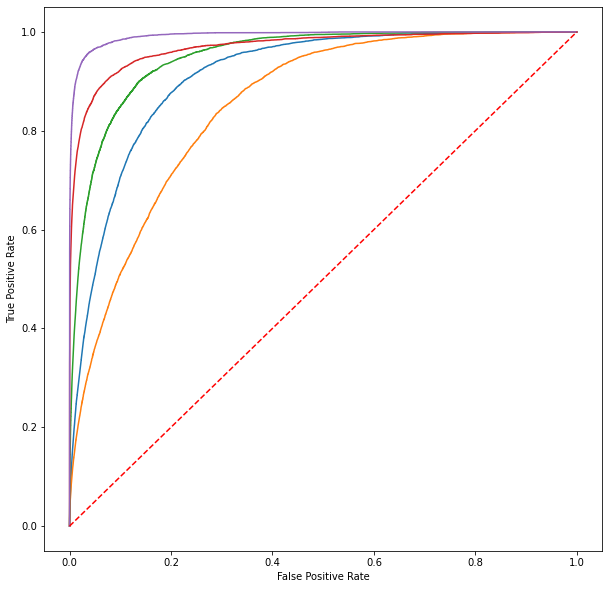

In [338]:
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(mean_fpr_nc,mean_tpr_nc)
plt.plot(mean_fpr_temp,mean_tpr_temp)
plt.plot(mean_fpr_nctemp,mean_tpr_nctemp )
plt.plot(mean_fpr_ckp, mean_tpr_ckp)
plt.plot(mean_fpr_deft, mean_tpr_deft)

plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

# Mobile

In [228]:
nc_mob = pd.read_csv('C:/Users/s3929438/Probabilities_mobile_onlyNC.csv')
temp_mob = pd.read_csv('C:/Users/s3929438/Probabilities_mobile_onlyTemp.csv')
nctemp_mob = pd.read_csv('C:/Users/s3929438/Probabilities_mobile_NC_TEMP.csv')
deft_mob = pd.read_csv('C:/Users/s3929438/Probabilities_XGboost_mobile.csv')
ckp_mob = pd.read_csv('C:/Users/s3929438/Probabilities_mobile_without_deft.csv')

## NC

In [170]:
fpr1_nc_mob, tpr1_nc_mob, _ = roc_curve(nc_mob.iloc[:,2], nc_mob.iloc[:,1])
fpr2_nc_mob, tpr2_nc_mob, _ = roc_curve(nc_mob.iloc[:,4], nc_mob.iloc[:,3])
fpr3_nc_mob, tpr3_nc_mob, _ = roc_curve(nc_mob.iloc[:,6], nc_mob.iloc[:,5])
fpr4_nc_mob, tpr4_nc_mob, _ = roc_curve(nc_mob.iloc[:,8], nc_mob.iloc[:,7])
fpr5_nc_mob, tpr5_nc_mob, _ = roc_curve(nc_mob.iloc[:,10], nc_mob.iloc[:,9])

In [171]:
fpr_list_nc_mob = [fpr1_nc_mob, fpr2_nc_mob,fpr3_nc_mob,fpr4_nc_mob,fpr5_nc_mob]
tpr_list_nc_mob = [tpr1_nc_mob, tpr2_nc_mob,tpr3_nc_mob,tpr4_nc_mob,tpr5_nc_mob]

In [172]:
max_length_nc_mob = max(len(fprs) for fprs in fpr_list_nc_mob)

In [173]:
for i in range(0,5):
    if len(fpr_list_nc_mob[i]) < max_length_nc_mob:
        fpr_list_nc_mob[i] = np.pad(fpr_list_nc_mob[i], (0, max_length_nc_mob - len(fpr_list_nc_mob[i])), constant_values=1)

In [174]:
for i in range(0,5):
    if len(tpr_list_nc_mob[i]) < max_length_nc_mob:
        tpr_list_nc_mob[i] = np.pad(tpr_list_nc_mob[i], (0, max_length_nc_mob - len(tpr_list_nc_mob[i])), constant_values=1)

In [175]:
mean_fpr_nc_mob = np.mean(fpr_list_nc_mob, axis=0)
mean_tpr_nc_mob = np.mean(tpr_list_nc_mob, axis=0)

## TEMP

In [191]:
fpr1_temp_mob, tpr1_temp_mob, _ = roc_curve(temp_mob.iloc[:,2], temp_mob.iloc[:,1])
fpr2_temp_mob, tpr2_temp_mob, _ = roc_curve(temp_mob.iloc[:,4], temp_mob.iloc[:,3])
fpr3_temp_mob, tpr3_temp_mob, _ = roc_curve(temp_mob.iloc[:,6], temp_mob.iloc[:,5])
fpr4_temp_mob, tpr4_temp_mob, _ = roc_curve(temp_mob.iloc[:,8], temp_mob.iloc[:,7])
fpr5_temp_mob, tpr5_temp_mob, _ = roc_curve(temp_mob.iloc[:,10], temp_mob.iloc[:,9])

In [192]:
fpr_list_temp_mob = [fpr1_temp_mob, fpr2_temp_mob,fpr3_temp_mob,fpr4_temp_mob,fpr5_temp_mob]
tpr_list_temp_mob = [tpr1_temp_mob, tpr2_temp_mob,tpr3_temp_mob,tpr4_temp_mob,tpr5_temp_mob]

In [193]:
max_length_temp_mob = max(len(fprs) for fprs in fpr_list_temp_mob)

In [194]:
for i in range(0,5):
    if len(fpr_list_temp_mob[i]) < max_length_temp_mob:
        fpr_list_temp_mob[i] = np.pad(fpr_list_temp_mob[i], (0, max_length_temp_mob - len(fpr_list_temp_mob[i])), constant_values=1)

In [195]:
for i in range(0,5):
    if len(tpr_list_temp_mob[i]) < max_length_temp_mob:
        tpr_list_temp_mob[i] = np.pad(tpr_list_temp_mob[i], (0, max_length_temp_mob - len(tpr_list_temp_mob[i])), constant_values=1)

In [196]:
mean_fpr_temp_mob = np.mean(fpr_list_temp_mob, axis=0)
mean_tpr_temp_mob = np.mean(tpr_list_temp_mob, axis=0)

## NC + TEMP

In [214]:
fpr1_nctemp_mob, tpr1_nctemp_mob, _ = roc_curve(nctemp_mob.iloc[:,2], nctemp_mob.iloc[:,1])
fpr2_nctemp_mob, tpr2_nctemp_mob, _ = roc_curve(nctemp_mob.iloc[:,4], nctemp_mob.iloc[:,3])
fpr3_nctemp_mob, tpr3_nctemp_mob, _ = roc_curve(nctemp_mob.iloc[:,6], nctemp_mob.iloc[:,5])
fpr4_nctemp_mob, tpr4_nctemp_mob, _ = roc_curve(nctemp_mob.iloc[:,8], nctemp_mob.iloc[:,7])
fpr5_nctemp_mob, tpr5_nctemp_mob, _ = roc_curve(nctemp_mob.iloc[:,10], nctemp_mob.iloc[:,9])

In [215]:
fpr_list_nctemp_mob = [fpr1_nctemp_mob, fpr2_nctemp_mob,fpr3_nctemp_mob,fpr4_nctemp_mob,fpr5_nctemp_mob]
tpr_list_nctemp_mob = [tpr1_nctemp_mob, tpr2_nctemp_mob,tpr3_nctemp_mob,tpr4_nctemp_mob,tpr5_nctemp_mob]

In [216]:
max_length_nctemp_mob = max(len(fprs) for fprs in fpr_list_nctemp_mob)

In [217]:
for i in range(0,5):
    if len(fpr_list_nctemp_mob[i]) < max_length_nctemp_mob:
        fpr_list_nctemp_mob[i] = np.pad(fpr_list_nctemp_mob[i], (0, max_length_nctemp_mob - len(fpr_list_nctemp_mob[i])), constant_values=1)

In [218]:
for i in range(0,5):
    if len(tpr_list_nctemp_mob[i]) < max_length_nctemp_mob:
        tpr_list_nctemp_mob[i] = np.pad(tpr_list_nctemp_mob[i], (0, max_length_nctemp_mob - len(tpr_list_nctemp_mob[i])), constant_values=1)

In [219]:
mean_fpr_nctemp_mob = np.mean(fpr_list_nctemp_mob, axis=0)
mean_tpr_nctemp_mob = np.mean(tpr_list_nctemp_mob, axis=0)

## CKP

In [229]:
fpr1_ckp_mob, tpr1_ckp_mob, _ = roc_curve(ckp_mob.iloc[:,2], ckp_mob.iloc[:,1])
fpr2_ckp_mob, tpr2_ckp_mob, _ = roc_curve(ckp_mob.iloc[:,4], ckp_mob.iloc[:,3])
fpr3_ckp_mob, tpr3_ckp_mob, _ = roc_curve(ckp_mob.iloc[:,6], ckp_mob.iloc[:,5])
fpr4_ckp_mob, tpr4_ckp_mob, _ = roc_curve(ckp_mob.iloc[:,8], ckp_mob.iloc[:,7])
fpr5_ckp_mob, tpr5_ckp_mob, _ = roc_curve(ckp_mob.iloc[:,10], ckp_mob.iloc[:,9])

In [230]:
fpr_list_ckp_mob = [fpr1_ckp_mob, fpr2_ckp_mob,fpr3_ckp_mob,fpr4_ckp_mob,fpr5_ckp_mob]
tpr_list_ckp_mob = [tpr1_ckp_mob, tpr2_ckp_mob,tpr3_ckp_mob,tpr4_ckp_mob,tpr5_ckp_mob]

In [231]:
max_length_ckp_mob = max(len(fprs) for fprs in fpr_list_ckp_mob)

In [232]:
for i in range(0,5):
    if len(fpr_list_ckp_mob[i]) < max_length_ckp_mob:
        fpr_list_ckp_mob[i] = np.pad(fpr_list_ckp_mob[i], (0, max_length_ckp_mob - len(fpr_list_ckp_mob[i])), constant_values=1)

In [233]:
for i in range(0,5):
    if len(tpr_list_ckp_mob[i]) < max_length_ckp_mob:
        tpr_list_ckp_mob[i] = np.pad(tpr_list_ckp_mob[i], (0, max_length_ckp_mob - len(tpr_list_ckp_mob[i])), constant_values=1)

In [234]:
mean_fpr_ckp_mob = np.mean(fpr_list_ckp_mob, axis=0)
mean_tpr_ckp_mob = np.mean(tpr_list_ckp_mob, axis=0)

## DEFT

In [198]:
fpr1_deft_mob, tpr1_deft_mob, _ = roc_curve(deft_mob.iloc[:,2], deft_mob.iloc[:,1])
fpr2_deft_mob, tpr2_deft_mob, _ = roc_curve(deft_mob.iloc[:,4], deft_mob.iloc[:,3])
fpr3_deft_mob, tpr3_deft_mob, _ = roc_curve(deft_mob.iloc[:,6], deft_mob.iloc[:,5])
fpr4_deft_mob, tpr4_deft_mob, _ = roc_curve(deft_mob.iloc[:,8], deft_mob.iloc[:,7])
fpr5_deft_mob, tpr5_deft_mob, _ = roc_curve(deft_mob.iloc[:,10], deft_mob.iloc[:,9])

In [199]:
fpr_list_deft_mob = [fpr1_deft_mob, fpr2_deft_mob,fpr3_deft_mob,fpr4_deft_mob,fpr5_deft_mob]
tpr_list_deft_mob = [tpr1_deft_mob, tpr1_deft_mob,tpr1_deft_mob,tpr1_deft_mob,tpr1_deft_mob]

In [200]:
max_length_deft_mob = max(len(fprs) for fprs in fpr_list_deft_mob)

In [201]:
for i in range(0,5):
    if len(fpr_list_deft_mob[i]) < max_length_deft_mob:
        fpr_list_deft_mob[i] = np.pad(fpr_list_deft_mob[i], (0, max_length_deft_mob - len(fpr_list_deft_mob[i])), constant_values=1)

In [202]:
for i in range(0,5):
    if len(tpr_list_deft_mob[i]) < max_length_deft_mob:
        tpr_list_deft_mob[i] = np.pad(tpr_list_deft_mob[i], (0, max_length_deft_mob - len(tpr_list_deft_mob[i])), constant_values=1)

In [203]:
mean_fpr_deft_mob = np.mean(fpr_list_deft_mob, axis=0)
mean_tpr_deft_mob = np.mean(tpr_list_deft_mob, axis=0)

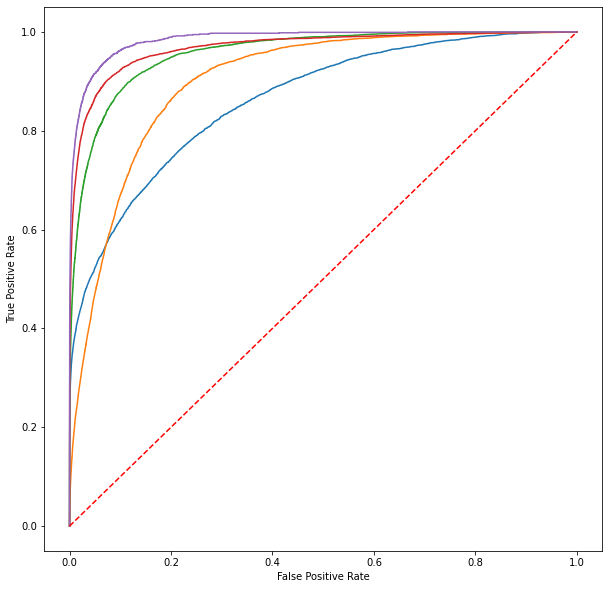

In [235]:
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(mean_fpr_nc_mob,mean_tpr_nc_mob)
plt.plot(mean_fpr_temp_mob,mean_tpr_temp_mob)
plt.plot(mean_fpr_nctemp_mob,mean_tpr_nctemp_mob )
plt.plot(mean_fpr_ckp_mob, mean_tpr_ckp_mob)
plt.plot(mean_fpr_deft_mob, mean_tpr_deft_mob)

plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

# Tablet

In [299]:
nc_tab = pd.read_csv('C:/Users/s3929438/Probabilities_tablet_onlyNC.csv')
temp_tab = pd.read_csv('C:/Users/s3929438/Probabilities_tablet_onlyTemp.csv')
nctemp_tab = pd.read_csv('C:/Users/s3929438/Probabilities_tablet_NC_TEMP.csv')
deft_tab = pd.read_csv('C:/Users/s3929438/Probabilities_XGboost_tablet.csv')
ckp_tab = pd.read_csv('C:/Users/s3929438/Probabilities_tablet_without_deft.csv')

## NC

In [245]:
fpr1_nc_tab, tpr1_nc_tab, _ = roc_curve(nc_tab.iloc[:,2], nc_tab.iloc[:,1])
fpr2_nc_tab, tpr2_nc_tab, _ = roc_curve(nc_tab.iloc[:,4], nc_tab.iloc[:,3])
fpr3_nc_tab, tpr3_nc_tab, _ = roc_curve(nc_tab.iloc[:,6], nc_tab.iloc[:,5])
fpr4_nc_tab, tpr4_nc_tab, _ = roc_curve(nc_tab.iloc[:,8], nc_tab.iloc[:,7])
fpr5_nc_tab, tpr5_nc_tab, _ = roc_curve(nc_tab.iloc[:,10], nc_tab.iloc[:,9])

In [246]:
fpr_list_nc_tab = [fpr1_nc_tab, fpr2_nc_tab,fpr3_nc_tab,fpr4_nc_tab,fpr5_nc_tab]
tpr_list_nc_tab = [tpr1_nc_tab, tpr2_nc_tab,tpr3_nc_tab,tpr4_nc_tab,tpr5_nc_tab]

In [247]:
max_length_nc_tab = max(len(fprs) for fprs in fpr_list_nc_tab)

In [248]:
for i in range(0,5):
    if len(fpr_list_nc_tab[i]) < max_length_nc_tab:
        fpr_list_nc_tab[i] = np.pad(fpr_list_nc_tab[i], (0, max_length_nc_tab - len(fpr_list_nc_tab[i])), constant_values=1)

In [249]:
for i in range(0,5):
    if len(tpr_list_nc_tab[i]) < max_length_nc_tab:
        tpr_list_nc_tab[i] = np.pad(tpr_list_nc_tab[i], (0, max_length_nc_tab - len(tpr_list_nc_tab[i])), constant_values=1)

In [250]:
mean_fpr_nc_tab = np.mean(fpr_list_nc_tab, axis=0)
mean_tpr_nc_tab = np.mean(tpr_list_nc_tab, axis=0)

## TEMP

In [268]:
fpr1_temp_tab, tpr1_temp_tab, _ = roc_curve(temp_tab.iloc[:,2], temp_tab.iloc[:,1])
fpr2_temp_tab, tpr2_temp_tab, _ = roc_curve(temp_tab.iloc[:,4], temp_tab.iloc[:,3])
fpr3_temp_tab, tpr3_temp_tab, _ = roc_curve(temp_tab.iloc[:,6], temp_tab.iloc[:,5])
fpr4_temp_tab, tpr4_temp_tab, _ = roc_curve(temp_tab.iloc[:,8], temp_tab.iloc[:,7])
fpr5_temp_tab, tpr5_temp_tab, _ = roc_curve(temp_tab.iloc[:,10], temp_tab.iloc[:,9])

In [269]:
fpr_list_temp_tab = [fpr1_temp_tab, fpr2_temp_tab,fpr3_temp_tab,fpr4_temp_tab,fpr5_temp_tab]
tpr_list_temp_tab = [tpr1_temp_tab, tpr2_temp_tab,tpr3_temp_tab,tpr4_temp_tab,tpr5_temp_tab]

In [270]:
max_length_temp_tab = max(len(fprs) for fprs in fpr_list_temp_tab)

In [271]:
for i in range(0,5):
    if len(fpr_list_temp_tab[i]) < max_length_temp_tab:
        fpr_list_temp_tab[i] = np.pad(fpr_list_temp_tab[i], (0, max_length_temp_tab - len(fpr_list_temp_tab[i])), constant_values=1)

In [272]:
for i in range(0,5):
    if len(tpr_list_temp_tab[i]) < max_length_temp_tab:
        tpr_list_temp_tab[i] = np.pad(tpr_list_temp_tab[i], (0, max_length_temp_tab - len(tpr_list_temp_tab[i])), constant_values=1)

In [273]:
mean_fpr_temp_tab = np.mean(fpr_list_temp_tab, axis=0)
mean_tpr_temp_tab = np.mean(tpr_list_temp_tab, axis=0)

# NC +TEMP

In [284]:
fpr1_nctemp_tab, tpr1_nctemp_tab, _ = roc_curve(nctemp_tab.iloc[:,2], nctemp_tab.iloc[:,1])
fpr2_nctemp_tab, tpr2_nctemp_tab, _ = roc_curve(nctemp_tab.iloc[:,4], nctemp_tab.iloc[:,3])
fpr3_nctemp_tab, tpr3_nctemp_tab, _ = roc_curve(nctemp_tab.iloc[:,6], nctemp_tab.iloc[:,5])
fpr4_nctemp_tab, tpr4_nctemp_tab, _ = roc_curve(nctemp_tab.iloc[:,8], nctemp_tab.iloc[:,7])
fpr5_nctemp_tab, tpr5_nctemp_tab, _ = roc_curve(nctemp_tab.iloc[:,10], nctemp_tab.iloc[:,9])

In [285]:
fpr_list_nctemp_tab = [fpr1_nctemp_tab, fpr2_nctemp_tab,fpr3_nctemp_tab,fpr4_nctemp_tab,fpr5_nctemp_tab]
tpr_list_nctemp_tab = [tpr1_nctemp_tab, tpr2_nctemp_tab,tpr3_nctemp_tab,tpr4_nctemp_tab,tpr5_nctemp_tab]

In [286]:
max_length_nctemp_tab = max(len(fprs) for fprs in fpr_list_nctemp_tab)

In [287]:
for i in range(0,5):
    if len(fpr_list_nctemp_tab[i]) < max_length_nctemp_tab:
        fpr_list_nctemp_tab[i] = np.pad(fpr_list_nctemp_tab[i], (0, max_length_nctemp_tab - len(fpr_list_nctemp_tab[i])), constant_values=1)

In [288]:
for i in range(0,5):
    if len(tpr_list_nctemp_tab[i]) < max_length_nctemp_tab:
        tpr_list_nctemp_tab[i] = np.pad(tpr_list_nctemp_tab[i], (0, max_length_nctemp_tab - len(tpr_list_nctemp_tab[i])), constant_values=1)

In [289]:
mean_fpr_nctemp_tab = np.mean(fpr_list_nctemp_tab, axis=0)
mean_tpr_nctemp_tab = np.mean(tpr_list_nctemp_tab, axis=0)

## CKP

In [300]:
fpr1_ckp_tab, tpr1_ckp_tab, _ = roc_curve(ckp_tab.iloc[:,2], ckp_tab.iloc[:,1])
fpr2_ckp_tab, tpr2_ckp_tab, _ = roc_curve(ckp_tab.iloc[:,4], ckp_tab.iloc[:,3])
fpr3_ckp_tab, tpr3_ckp_tab, _ = roc_curve(ckp_tab.iloc[:,6], ckp_tab.iloc[:,5])
fpr4_ckp_tab, tpr4_ckp_tab, _ = roc_curve(ckp_tab.iloc[:,8], ckp_tab.iloc[:,7])
fpr5_ckp_tab, tpr5_ckp_tab, _ = roc_curve(ckp_tab.iloc[:,10], ckp_tab.iloc[:,9])

In [301]:
fpr_list_ckp_tab = [fpr1_ckp_tab, fpr2_ckp_tab,fpr3_ckp_tab,fpr4_ckp_tab,fpr5_ckp_tab]
tpr_list_ckp_tab = [tpr1_ckp_tab, tpr2_ckp_tab,tpr3_ckp_tab,tpr4_ckp_tab,tpr5_ckp_tab]

In [302]:
max_length_ckp_tab = max(len(fprs) for fprs in fpr_list_ckp_tab)

In [303]:
for i in range(0,5):
    if len(fpr_list_ckp_tab[i]) < max_length_ckp_tab:
        fpr_list_ckp_tab[i] = np.pad(fpr_list_ckp_tab[i], (0, max_length_ckp_tab - len(fpr_list_ckp_tab[i])), constant_values=1)

In [304]:
for i in range(0,5):
    if len(tpr_list_ckp_tab[i]) < max_length_ckp_tab:
        tpr_list_ckp_tab[i] = np.pad(tpr_list_ckp_tab[i], (0, max_length_ckp_tab - len(tpr_list_ckp_tab[i])), constant_values=1)

In [305]:
mean_fpr_ckp_tab = np.mean(fpr_list_ckp_tab, axis=0)
mean_tpr_ckp_tab = np.mean(tpr_list_ckp_tab, axis=0)

## DEFT

In [251]:
fpr1_deft_tab, tpr1_deft_tab, _ = roc_curve(deft_tab.iloc[:,2], deft_tab.iloc[:,1])
fpr2_deft_tab, tpr2_deft_tab, _ = roc_curve(deft_tab.iloc[:,4], deft_tab.iloc[:,3])
fpr3_deft_tab, tpr3_deft_tab, _ = roc_curve(deft_tab.iloc[:,6], deft_tab.iloc[:,5])
fpr4_deft_tab, tpr4_deft_tab, _ = roc_curve(deft_tab.iloc[:,8], deft_tab.iloc[:,7])
fpr5_deft_tab, tpr5_deft_tab, _ = roc_curve(deft_tab.iloc[:,10], deft_tab.iloc[:,9])

In [252]:
fpr_list_deft_tab = [fpr1_deft_tab, fpr2_deft_tab,fpr3_deft_tab,fpr4_deft_tab,fpr5_deft_tab]
tpr_list_deft_tab = [tpr1_deft_tab, tpr2_deft_tab,tpr3_deft_tab,tpr4_deft_tab,tpr5_deft_tab]

In [253]:
max_length_deft_tab = max(len(fprs) for fprs in fpr_list_deft_tab)

In [254]:
for i in range(0,5):
    if len(fpr_list_deft_tab[i]) < max_length_deft_tab:
        fpr_list_deft_tab[i] = np.pad(fpr_list_deft_tab[i], (0, max_length_deft_tab - len(fpr_list_deft_tab[i])), constant_values=1)

In [255]:
for i in range(0,5):
    if len(tpr_list_deft_tab[i]) < max_length_deft_tab:
        tpr_list_deft_tab[i] = np.pad(tpr_list_deft_tab[i], (0, max_length_deft_tab - len(tpr_list_deft_tab[i])), constant_values=1)

In [256]:
mean_fpr_deft_tab = np.mean(fpr_list_deft_tab, axis=0)
mean_tpr_deft_tab = np.mean(tpr_list_deft_tab, axis=0)

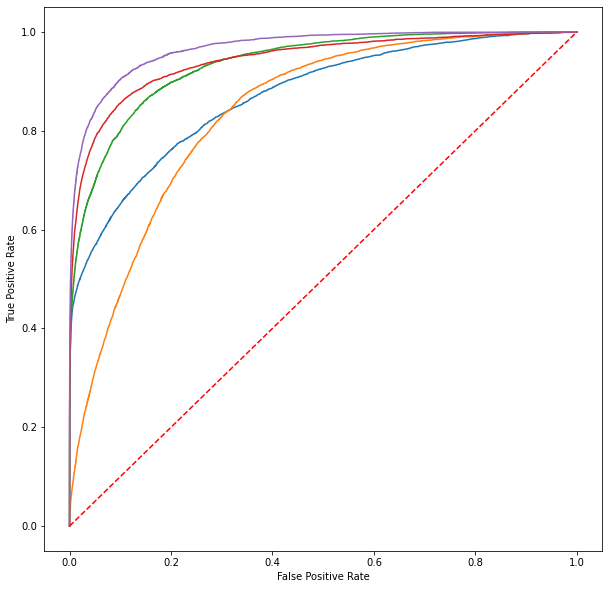

In [306]:
fig,ax = plt.subplots(figsize = (10,10))
plt.plot(mean_fpr_nc_tab,mean_tpr_nc_tab)
plt.plot(mean_fpr_temp_tab,mean_tpr_temp_tab)
plt.plot(mean_fpr_nctemp_tab,mean_tpr_nctemp_tab )
plt.plot(mean_fpr_ckp_tab, mean_tpr_ckp_tab)
plt.plot(mean_fpr_deft_tab, mean_tpr_deft_tab)

plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [311]:
def custom_format(x, pos):
    return f'{x*100:.0f}'

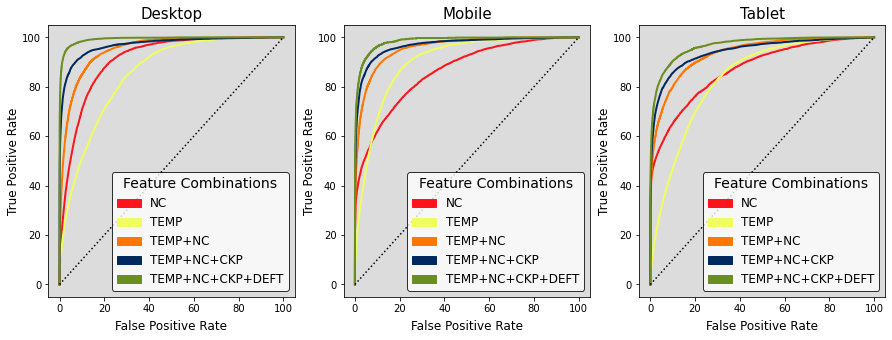

In [344]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15,5))

ax1.plot(mean_fpr_nc,mean_tpr_nc, color = '#FD151B', linewidth=2)
ax1.plot(mean_fpr_temp,mean_tpr_temp, color = '#EFFD5F', linewidth=2)
ax1.plot(mean_fpr_nctemp,mean_tpr_nctemp, color = '#ff7700', linewidth=2)
ax1.plot(mean_fpr_ckp, mean_tpr_ckp, color = '#01295F', linewidth=2)
ax1.plot(mean_fpr_deft, mean_tpr_deft, color = 'olivedrab', linewidth=2)
ax1.plot([0, 1], [0, 1],color='black', linestyle='dotted')

ax1.set_title('Desktop', fontsize = 15)
ax1.set_xlabel('False Positive Rate', fontsize = 12, labelpad=6)
ax1.set_ylabel('True Positive Rate', fontsize = 12, labelpad=2)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(custom_format))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(custom_format))
ax1.set_facecolor('gainsboro')
line1_patch = mpatches.Patch(color='#FD151B', label='NC')
line2_patch = mpatches.Patch(color='#EFFD5F', label='TEMP')
line3_patch = mpatches.Patch(color='#ff7700', label='TEMP+NC')
line4_patch = mpatches.Patch(color='#01295F', label='TEMP+NC+CKP')
line5_patch = mpatches.Patch(color='olivedrab', label='TEMP+NC+CKP+DEFT')

legend1 = ax1.legend(handles=[line1_patch, line2_patch, line3_patch, line4_patch, line5_patch],title='Feature Combinations',ncol=1,fontsize=12, loc = 'lower right',edgecolor='black')
legend1.get_title().set_fontsize('14')


ax2.plot(mean_fpr_nc_mob,mean_tpr_nc_mob, color = '#FD151B', linewidth=2)
ax2.plot(mean_fpr_temp_mob,mean_tpr_temp_mob, color = '#EFFD5F', linewidth=2)
ax2.plot(mean_fpr_nctemp_mob,mean_tpr_nctemp_mob, color = '#ff7700', linewidth=2 )
ax2.plot(mean_fpr_ckp_mob, mean_tpr_ckp_mob, color = '#01295F', linewidth=2)
ax2.plot(mean_fpr_deft_mob, mean_tpr_deft_mob, color = 'olivedrab', linewidth=2)
ax2.plot([0, 1], [0, 1],color='black', linestyle='dotted')

ax2.set_title('Mobile', fontsize=15)
ax2.set_xlabel('False Positive Rate',fontsize = 12, labelpad=6)
ax2.set_ylabel('True Positive Rate', fontsize = 12, labelpad=2)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(custom_format))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(custom_format))
ax2.set_facecolor('gainsboro')
line6_patch = mpatches.Patch(color='#FD151B', label='NC')
line7_patch = mpatches.Patch(color='#EFFD5F', label='TEMP')
line8_patch = mpatches.Patch(color='#ff7700', label='TEMP+NC')
line9_patch = mpatches.Patch(color='#01295F', label='TEMP+NC+CKP')
line10_patch = mpatches.Patch(color='olivedrab', label='TEMP+NC+CKP+DEFT')

legend2 = ax2.legend(handles=[line6_patch, line7_patch, line8_patch, line9_patch, line10_patch],title='Feature Combinations',ncol=1,fontsize=12, loc = 'lower right',edgecolor='black')
legend2.get_title().set_fontsize('14')


ax3.plot(mean_fpr_nc_tab,mean_tpr_nc_tab, color = '#FD151B', linewidth=2)
ax3.plot(mean_fpr_temp_tab,mean_tpr_temp_tab, color = '#EFFD5F', linewidth=2)
ax3.plot(mean_fpr_nctemp_tab,mean_tpr_nctemp_tab,color = '#ff7700', linewidth=2 )
ax3.plot(mean_fpr_ckp_tab, mean_tpr_ckp_tab, color = '#01295F', linewidth=2)
ax3.plot(mean_fpr_deft_tab, mean_tpr_deft_tab, color = 'olivedrab', linewidth=2)
ax3.plot([0, 1], [0, 1],color='black', linestyle='dotted')

ax3.set_title('Tablet',fontsize = 15 )
ax3.set_xlabel('False Positive Rate', fontsize = 12, labelpad=6)
ax3.set_ylabel('True Positive Rate', fontsize = 12, labelpad=2)
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(custom_format))
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(custom_format))
ax3.set_facecolor('gainsboro')

line11_patch = mpatches.Patch(color='#FD151B', label='NC')
line12_patch = mpatches.Patch(color='#EFFD5F', label='TEMP')
line13_patch = mpatches.Patch(color='#ff7700', label='TEMP+NC')
line14_patch = mpatches.Patch(color='#01295F', label='TEMP+NC+CKP')
line15_patch = mpatches.Patch(color='olivedrab', label='TEMP+NC+CKP+DEFT')

legend3 = ax3.legend(handles=[line11_patch, line12_patch, line13_patch, line14_patch, line15_patch],title='Feature Combinations',ncol=1,fontsize=12, loc = 'lower right',edgecolor='black')
legend3.get_title().set_fontsize('14')


plt.savefig('ROC_for_comparision_feature_steps.png')
plt.show()